# Filter Tracks in xAOD Events

This is a sample script that uses the ad-hoc analysis library to extract jet pt's from certain ATLAS xAOD events.

- Run Number
- Event Number
- Jet Eta
- Jet pt
- Number of tracks with pt > 1 GeV in the event.

The tracks entry means having to do a filter on a per-event basis: we want to count the number of tracks in each event that have `pt>1` GeV.

## Setup and Config

In [1]:
fname = r"file://G:/mc16_13TeV/AOD.16300985._000011.pool.root.1"

In [6]:
%%time
import sys
sys.path.append('..')
from clientlib.DataSets import EventDataSet
from cpplib.math_utils import DeltaR

Wall time: 4 ms


## Import the events into a Pandas array.

First thing we do is turn a dataset into an implicit stream of events.

In [3]:
%%time
f = EventDataSet(fname)
events = f.AsATLASEvents()

Wall time: 0 ns


We will get the stream of jets in several steps. We could do this in one step, but it is easier to read.

We now also include the `tracks` collection. Note that we apply a `Where` filter to it so that only those tracks that have a large enough pt survive our collection. This means the `event_info` tuple now contains, for each event:

- The `EventInfo` object (run number, etc.)
- A list of all jets
- A list of all tracks with `pt>1` GeV.

In [4]:
%%time
event_info = events \
            .Select("lambda e: (e.EventInfo('EventInfo'), e.Jets('AntiKt4EMTopoJets'), e.Tracks('InDetTrackParticles').Where(lambda t: t.pt() > 1000.0))")

Wall time: 0 ns


The `event_info` iterator is a sequence of events - one per event. We want it to be one per jet. We use the `SelectMany` function to change the sequence into one of jets. Note that `Select` is used in the interior - this is because `e1[1]` is an array of the jets in the event - so it is already a sequence.

In [7]:
jet_info = event_info \
            .SelectMany('lambda e1: e1[1].Select(lambda j: (e1[0],j,e1[2].Where(lambda t: DeltaR(t.eta(), t.phi(), j.eta(), j.phi())< 0.2)))')

Now we have a sequnce with an entry for each jet. Now we are ready to generate the tuple of data we want to writ eout. Note the conversion from MeV to GeV for the jet's pt.

In [8]:
jet_data = jet_info \
            .Select('lambda jinfo: (jinfo[0].runNumber(), jinfo[0].eventNumber(), jinfo[1].pt()/1000.0, jinfo[1].eta(), jinfo[2].Count())')

Finally, we want to keep only jets with a `pt` of at least 40 GeV.

In [9]:
jet_filtered = jet_data \
                .Where('lambda jinfo1: jinfo1[2] > 40.0')

And finally turn it into a pandas data frame. Each row has the information associated with a single jet.

At this point no execution happens - a "future" is now setup with the pandas dataframe.

In [10]:
%%time
training_df = jet_filtered.AsPandasDF(columns=['Run', 'Event', 'JetPt', 'JetEta', 'nTracks'])

Wall time: 0 ns


Finally, we turn it into something real. The following steps occur:

1. Some C++ code is written to access, read the xAOD jet's, create a ttree, and write it out.
1. A docker container with the ATLAS envrionment is started. The code and the data file location are mapped into it.
1. The code is compiled, and then run.
1. The output ROOT file is loaded with uproot and a DF is created.
1. All that temporary code and data is removed.

There is a fair amount of log file information that appears in the notebook engine window. At the moement that is not correctly redirected here - so you can see evidence of it running there.

In [11]:
%%time
df = training_df.value()

Wall time: 38.6 s


## The Dataframe

Now we can play with the dataframe as we wish.

In [12]:
df

,Run,Event,JetPt,JetEta,nTracks
0,300000.0,16000310.0,257.316437,1.438426,18.0
1,300000.0,16000310.0,253.132324,0.656501,11.0
2,300000.0,16000310.0,47.169453,-2.648296,1.0
3,300000.0,16000256.0,386.493408,2.073497,7.0
4,300000.0,16000256.0,339.724030,-0.082004,6.0
5,300000.0,16002559.0,205.481918,-1.160439,9.0
6,300000.0,16002559.0,145.919022,1.104241,7.0
7,300000.0,16002811.0,367.607086,1.182012,25.0
8,300000.0,16002811.0,284.545380,-0.467615,11.0
9,300000.0,16002811.0,57.873211,-1.149017,8.0


In [13]:
%%time
import matplotlib.pyplot as plt

Wall time: 932 ms


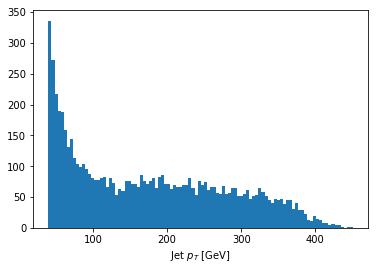

In [14]:
_ = plt.hist(df.JetPt, bins=100)
_ = plt.xlabel("Jet $p_T$ [GeV]")

Note the cut off at 40 GeV on the low end.

Wall time: 48 ms


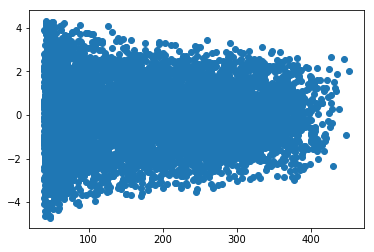

In [16]:
%%time
_ = plt.scatter(df.JetPt, df.JetEta)

As expected we can see the higher pt jets tend to be more central

We can also look at the number of tracks as a function of jet $p_T$.

Wall time: 43 ms


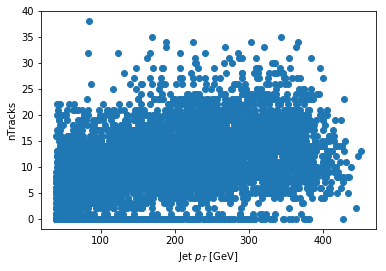

In [20]:
%%time
_ = plt.scatter(df.JetPt, df.nTracks)
_ = plt.xlabel('Jet $p_T$ [GeV]')
_ = plt.ylabel('nTracks')

## Limitations

This is demo code. There are a number of limitations:

- Only Jets, Tracks, and EventInfo is understood (easy to add new C++ collections or objects). You can alter the name of the collection you want to access.
- Basic operations are possible, like jet.pt()/1000.0. But no effor had been made to have a complete set of operations yet.
- Only a single query at a time is possible. However you can create multiple columns in the dataframe (with jet pt and eta, for example).
- Obviously, tuples quickly become unweildy. Named tuples would be the obvious thing to use - and there is no techincal reason not to use them. Eventually.
- We'd really just like to calculate the number of tracks that are near a single jet axis. This requires proper implementation of the `DeltaR` function.